## Moldulos a serem importados

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

import metrics
from metrics import ClassificationMetrics
from sklearn import metrics as skmetrics

In [27]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer

In [28]:
from gensim.corpora.dictionary import Dictionary
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/spinosa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/spinosa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Pré-processamento do dataset

In [30]:
path_ = "sentiment_labelled_sentences/"
amazon_ = path_ + 'amazon_cells_labelled.txt'
df = pd.read_csv(amazon_, delimiter='\t', header=None, names=['text','sentiment'])

## Dados e distribuição

In [31]:
df.head(5)

,text,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1000 non-null   object
 1   sentiment  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [33]:
df.isna().sum()

text         0
sentiment    0
dtype: int64

In [34]:
df['sentiment'].value_counts()

0    500
1    500
Name: sentiment, dtype: int64

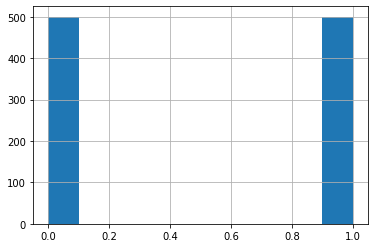

In [35]:
df['sentiment'].hist();

### Split X e y

In [36]:
X = np.char.lower(list(df['text'].values))
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Pré-Processamento dos dados

### Tokenização

In [37]:
X_train_tokenized = [[word for word in word_tokenize(text) if word.isalpha()] for text in X_train]
X_test_tokenized = [[word for word in word_tokenize(text) if word.isalpha()] for text in X_test]

### Remoção de StopWords

In [38]:
english_stopwords = stopwords.words('english')
X_train_tokenized_whithout_stopwords = [[token for token in tokens_list if token not in english_stopwords] for tokens_list in X_train_tokenized]

X_test_tokenized_whithout_stopwords = [[token for token in tokens_list if token not in english_stopwords] for tokens_list in X_test_tokenized]

### Stemming ou Lemmatization

In [39]:
lematizer_lancaster = LancasterStemmer()

In [40]:
X_train_lemmatizated = [[lematizer_lancaster.stem(token) for token in tokens_list] for tokens_list in X_train_tokenized_whithout_stopwords]

X_test_lemmatizated = [[lematizer_lancaster.stem(token) for token in tokens_list] for tokens_list in X_test_tokenized_whithout_stopwords]

## Vectorização

In [41]:
dictionary = Dictionary(X_train_lemmatizated + X_test_lemmatizated)

In [42]:
train_corpus = [np.array(dictionary.doc2bow(doc)) for doc in X_train_lemmatizated]
test_corpus = [np.array(dictionary.doc2bow(doc)) for doc in X_test_lemmatizated]

In [43]:
def bow_to_sparce(corpus, max_vocab):
    sparce_vec = list()
    for doc in corpus:
        try:
            idxs = doc[:,0]
        except IndexError:
            idxs = False
        arr = np.zeros(shape=(max_vocab, ))
        arr[idxs] = 1
        sparce_vec.append(arr)
    sparce_vec = np.array(sparce_vec)
    return sparce_vec

In [44]:
train_vec = bow_to_sparce(train_corpus, len(dictionary))
test_vec = bow_to_sparce(test_corpus, len(dictionary))

In [45]:
model = MultinomialNB()
model.fit(train_vec, y_train)
y_pred = model.predict(test_vec)

### Pre-processamento, Vectorização e Modelo do Gensim

In [46]:
vectorizer = CountVectorizer(stop_words='english')
count_train = vectorizer.fit_transform(X_train)
count_test  = vectorizer.transform(X_test)

In [47]:
model = MultinomialNB()
model.fit(count_train, y_train)
y_pred_auto = model.predict(count_test)

In [49]:
my_metrics = ClassificationMetrics(y_true=y_test, y_pred=y_pred)
automatic_metrics = ClassificationMetrics(y_true=y_test, y_pred=y_pred_auto)

## Metricas

### Minha Acuracia

In [50]:
my_metrics.accuracy_score, automatic_metrics.accuracy_score

(0.7966666666666666, 0.8)

### sklearn Acurácia

In [52]:
skmetrics.accuracy_score(y_true=y_test, y_pred=y_pred), skmetrics.accuracy_score(y_true=y_test, y_pred=y_pred_auto) 

(0.7966666666666666, 0.8)

### Minha precisão

In [53]:
my_metrics.precision_score, automatic_metrics.precision_score

(0.7999265605875153, 0.8009863701578193)

### sklearn precisão

In [54]:
skmetrics.precision_score(y_true=y_test, y_pred=y_pred, average='weighted'), skmetrics.precision_score(y_true=y_test, y_pred=y_pred_auto, average='weighted') 

(0.7999265605875153, 0.8009863701578193)

### Meu recall

In [55]:
my_metrics.recall_score, automatic_metrics.recall_score

(0.7966666666666666, 0.8)

### sklearn recall

In [57]:
skmetrics.recall_score(y_true=y_test, y_pred=y_pred, average='weighted'), skmetrics.recall_score(y_true=y_test, y_pred=y_pred_auto, average='weighted')

(0.7966666666666666, 0.8)

### Meu f1-score

In [58]:
my_metrics.f1_score, automatic_metrics.f1_score

(0.7982932856321472, 0.8004928812268263)

### sklearn f1-score

In [59]:
skmetrics.f1_score(y_true=y_test, y_pred=y_pred, average='weighted'), skmetrics.f1_score(y_true=y_test, y_pred=y_pred_auto, average='weighted')

(0.7956997668997668, 0.7995985547972703)

In [66]:
df = pd.DataFrame([my_metrics.metrics_matrix, automatic_metrics.metrics_matrix])  
df.index = ['manual','automatic']
df

,accuracy,precision,recall,f1
manual,0.796667,0.799927,0.796667,0.798293
automatic,0.800000,0.800986,0.800000,0.800493
